# Introduction to Dask

**Attribution**: The following notebook is based on the great notebook created by Ryan Abernathey in the Earth and Environmental Data Science book ([link](https://earth-env-data-science.github.io/lectures/dask/dask_arrays.html))

You can access this notebook (in a Docker image) on this [GitHub repo](https://github.com/HamedAlemo/dask-tutorial).

## What is Dask?

Dask is a Python library that provides flexible parallel computing and distributed data processing capabilities. It is designed to handle larger-than-memory computations and parallelize tasks across multiple cores and even distributed clusters. Dask's primary goal is to make it easier for developers to scale their data analysis and processing workflows while maintaining a familiar and Pythonic interface.

Dask is composed of two components: 1) Task Scheduler, and 2) “Big Data” collections. These collections include parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of dynamic task schedulers.

![Dask Overview](https://docs.dask.org/en/stable/_images/dask-overview.svg)




Dask overview (source: [Dask Documentation](https://docs.dask.org/en/stable/))

## Dask Arrays

A dask array looks and feels a lot like a NumPy array.
However, a dask array doesn't directly hold any data.
Instead, it symbolically represents the computations needed to generate the data.
Nothing is actually computed until the actual numerical values are needed.
This mode of operation is called "lazy"; it allows one to build up complex, large calculations symbolically before turning them over the scheduler for execution.

Dask arrays coordinate many NumPy arrays arranged into a grid. These arrays may live on disk or on other machines.

![Dask Array](https://docs.dask.org/en/stable/_images/dask-array.svg)

(source [Dask Documentation](https://docs.dask.org/en/stable/array.html))

If we want to create a NumPy array of all ones, we do it like this:

In [1]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

This array contains ~ 30 MB of data:

In [2]:
ones_np.nbytes / (1024 * 1024)

30.517578125

Now let's create the same array using dask's array interface.

In [3]:
import dask.array as da
ones = da.ones(shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

The dask array representation reveals the concept of "chunks". "Chunks" describes how the array is split into sub-arrays. We did not specify any chunks, so Dask just used one single chunk for the array. This is not much different from a NumPy array at this point.

### Specifying Chunks

However, we could have split up the array into many chunks.

There are [several ways to specify chunks](https://dask.pydata.org/en/latest/array-chunks.html).
In this lecture, we will use a block shape.

In [4]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Notice that we just see a symbolic represetnation of the array, including its shape, dtype, and chunksize.
No data has been generated yet.
When we call `.compute()` on a dask array, the computation is trigger and the dask array becomes a NumPy array.

In [5]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In order to understand what happened when we called `.compute()`, we can visualize the dask _graph_, the symbolic operations that make up the array

In [6]:
ones.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

Our array has four chunks. To generate it, dask calls `np.ones` four times and then concatenates this together into one array.

Rather than immediately loading a dask array (which puts all the data into RAM), it is more common to want to reduce the data somehow. For example

In [7]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

Here we see dask's strategy for finding the sum. This simple example illustrates the beauty of dask: it automatically designs an algorithm appropriate for custom operations with big data. 

If we make our operation more complex, the graph gets more complex.

In [8]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

### A Bigger Calculation

The examples above were toy examples; the data (32 MB) is nowhere nearly big enough to warrant the use of dask.

We can make it a lot bigger!

In [9]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

dask.array<ones_like, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [10]:
big_ones.nbytes / (1024 * 1024)

6103.515625

This dataset is 3.2 GB, rather MB! This is probably close to or greater than the amount of available RAM than you have in your computer. Nevertheless, dask has no problem working on it.

_Do not try to `.visualize()` this array!_

When doing a big calculation, dask also has some tools to help us understand what is happening under the hood

In [11]:
from dask.diagnostics import ProgressBar

big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

with ProgressBar():
    result = big_calc.compute()
result

[########################################] | 100% Completed | 933.37 ms


1.0

### Reduction 

All the usual NumPy methods work on dask arrays (Check this section on Dask Documentation to learn what NumPy methods work in Dask which ones don't).
You can also apply NumPy function directly to a dask array, and it will stay lazy.

In [12]:
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=0)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(4000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

Plotting also triggers computation, since we need the actual values

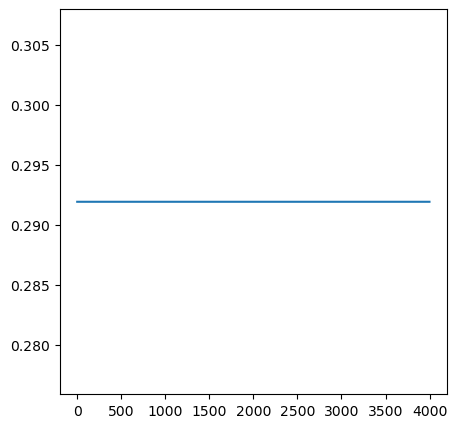

In [13]:
from matplotlib import pyplot as plt
# plt.rcParams['figure.figsize'] = (12,8)
plt.figure(figsize = (5, 5))
plt.plot(big_ones_reduce)
plt.draw()

## Distributed Clusters

Once we are ready to make a bigger calculation with dask, we can use a Dask [Distributed](http://distributed.dask.org/en/stable/) cluster.

```{warning}
A common mistake is to move to distributed mode too soon.
For smaller data, distributed will actually be _much slower_ than the default multi-threaded scheduler or **not using Dask at all**.
You should only use distributed when your data is much larger than what your computer can handle in memory.
```

### Local Cluster

A local cluster uses all the CPU cores of the machine it is running on.
For our cloud-based Jupyterlab environments, that is just 2 cores--not very much.
However, it's good to know about.

In [14]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

2024-10-10 17:19:20,314 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-0zgq7n3y', purging
2024-10-10 17:19:20,314 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-eb4ori9z', purging
2024-10-10 17:19:20,315 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-2x4luim2', purging
2024-10-10 17:19:20,315 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ey9msas4', purging
2024-10-10 17:19:20,315 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-s42w6mdc', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 5,Total memory: 7.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37505,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 5
Started: Just now,Total memory: 7.67 GiB
Comm: tcp://127.0.0.1:45099,Total threads: 1
Dashboard: http://127.0.0.1:35475/status,Memory: 1.53 GiB
Nanny: tcp://127.0.0.1:45123,


Note that the "Dashboard" link will open a new page where you can monitor a computation's progress.

In [15]:
big_calc.compute()

1.0

Here is another bigger calculation.

In [16]:
random_values = da.random.normal(size=(2e8,), chunks=(1e6,))
hist, bins = da.histogram(random_values, bins=100, range=[-5, 5]) 
hist

dask.array<sum-aggregate, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

Trigger the histogram computation:

In [17]:
hist_c = hist.compute()

Plot the histogram:

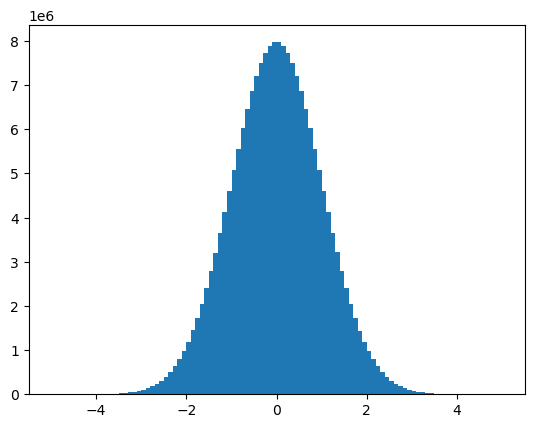

In [18]:
x = 0.5 * (bins[1:] + bins[:-1])
width = np.diff(bins)
plt.bar(x, hist_c, width);